# Part 2: Metal vs. Non-Metal Classification

This notebook trains a CNN to classify radar signals as either metal or non-metal objects.

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

from radar_utils import generate_radar_cube, process_radar_cube, get_random_scenario, N_chirps, N_samples

## 1. Data Generation

Generate synthetic radar data with global normalization.

In [16]:
num_samples_dataset = 1000
X_data = []
y_data = []

print("Generating dataset...")
for i in range(num_samples_dataset):
    label_int = np.random.randint(0, 2)
    if label_int == 0:
        scenario_type = 'non_metal'
    else:
        scenario_type = 'metal'
        
    targets = get_random_scenario(scenario_type)
    cube = generate_radar_cube(N_chirps, N_samples, targets, noise_level=0.05)
    rd_map = process_radar_cube(cube)
    
    # Preprocessing: Take magnitude and normalize
    mag = np.abs(rd_map)
    mag = 20 * np.log10(mag + 1e-9)
    
    # Thresholding to remove low noise
    mag[mag < 50] = 0
    
    # Global Normalization (The FIX)
    global_max = 120.0
    mag = mag / global_max
    mag = np.clip(mag, 0, 1.0)
    
    X_data.append(mag)
    y_data.append(label_int)
    
X_data = np.array(X_data)
y_data = np.array(y_data)

# Add channel dimension for CNN (N, C, H, W)
X_data = X_data[:, np.newaxis, :, :]

print(f"Dataset shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")

Generating dataset...
Dataset shape: (1000, 1, 128, 600)
Labels shape: (1000,)


## 2. Train/Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 800
Test samples: 200


## 3. Model Definition

In [18]:
class RadarCNN(nn.Module):
    def __init__(self):
        super(RadarCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        # Input: (1, 128, 600)
        # Pool1: (16, 64, 300)
        # Pool2: (32, 32, 150)
        # Pool3: (64, 16, 75)
        # Flatten: 64 * 16 * 75 = 76800
        self.fc1 = nn.Linear(64 * 16 * 75, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = RadarCNN()
print("Model created successfully!")

Model created successfully!


## 4. Training

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training...")
epochs = 15
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Starting training...
Epoch 1/15, Loss: 0.8548
Epoch 2/15, Loss: 0.0611
Epoch 3/15, Loss: 0.0238
Epoch 4/15, Loss: 0.0548
Epoch 5/15, Loss: 0.0064
Epoch 6/15, Loss: 0.0028
Epoch 7/15, Loss: 0.0089
Epoch 8/15, Loss: 0.0044
Epoch 9/15, Loss: 0.0020
Epoch 10/15, Loss: 0.0005
Epoch 11/15, Loss: 0.0006
Epoch 12/15, Loss: 0.0034
Epoch 13/15, Loss: 0.0057
Epoch 14/15, Loss: 0.0009
Epoch 15/15, Loss: 0.0003


## 5. Evaluation

Test Accuracy: 100.00%

Confusion Matrix:
[[ 95   0]
 [  0 105]]


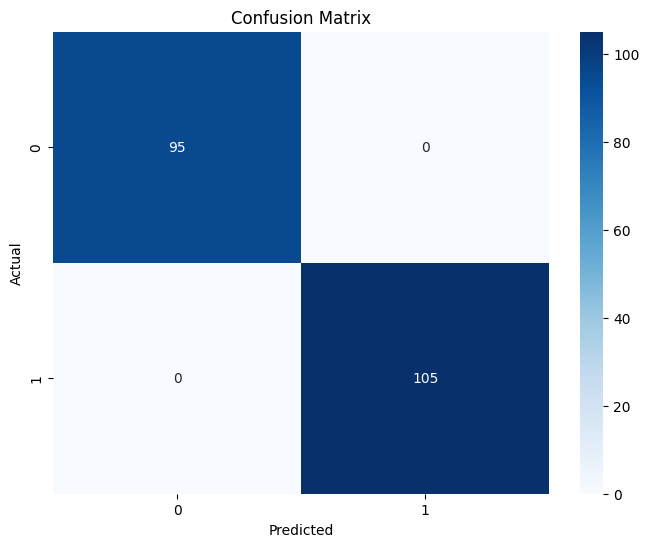

In [20]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    
    cm = confusion_matrix(y_test_tensor, predicted)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## 6. Save Model

In [21]:
torch.save(model.state_dict(), 'radar_cnn_model.pth')
print("Model saved to radar_cnn_model.pth")

Model saved to radar_cnn_model.pth
